In [104]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [106]:
# Download Inception v3 weights to local machine
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import Inception v3 Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
pre_trained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights=None)

# Load Inception v3 weights into model
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model.load_weights(local_weights_file)

--2022-02-21 22:44:14--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   201MB/s    in 0.4s    

2022-02-21 22:44:15 (201 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [107]:
for layer in pre_trained_model.layers:
    layer.trainable = False

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 74, 74, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_282 (Batch  (None, 74, 74, 32)  96          ['conv2d_282[0][0]']             
 Normalization)                                                                                   
                                                                                       

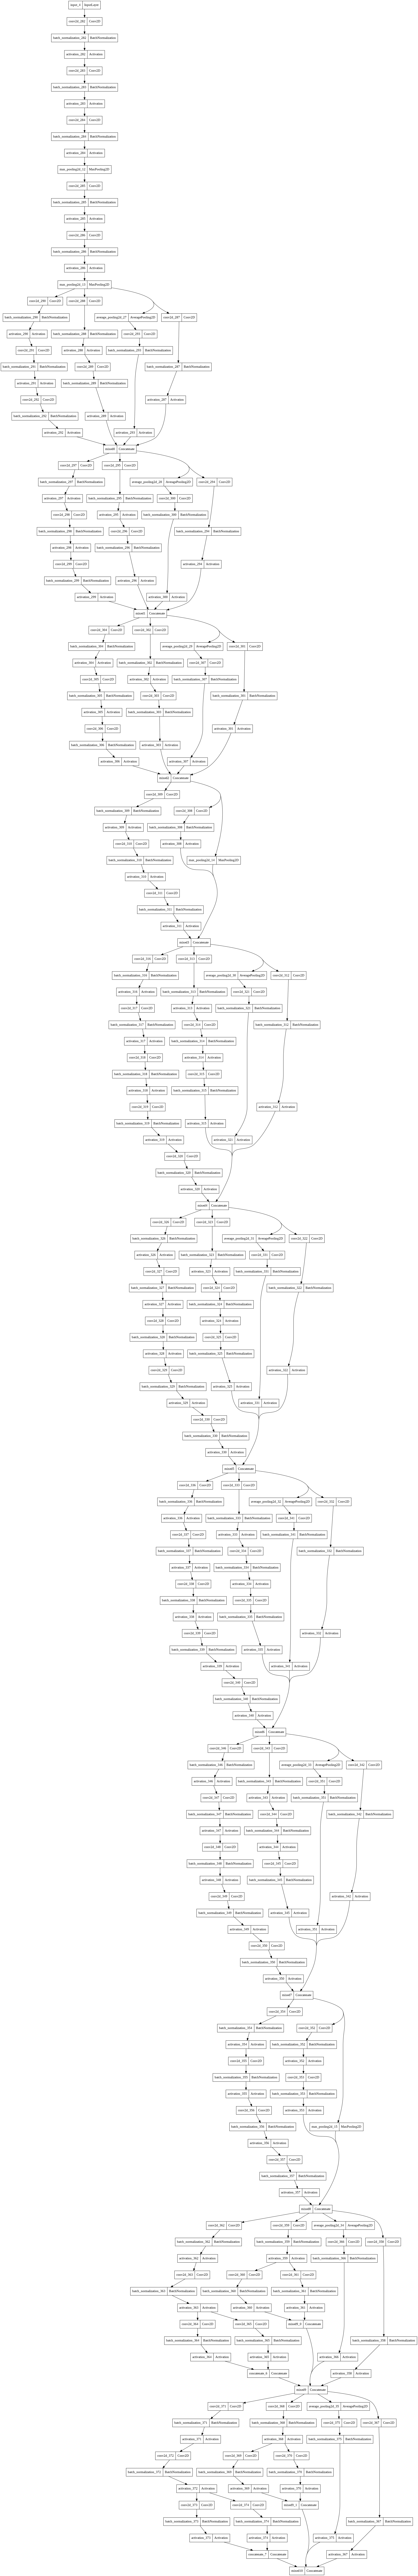

In [108]:
pre_trained_model.summary()
plot_model(pre_trained_model, to_file='inception_v3_model.png', show_shapes=False, show_layer_names=True)

In [109]:
last_layer = pre_trained_model.get_layer('mixed8')
last_output = last_layer.output

In [110]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(14, activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 74, 74, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_282 (Batch  (None, 74, 74, 32)  96          ['conv2d_282[0][0]']             
 Normalization)                                                                                   
                                                                                            

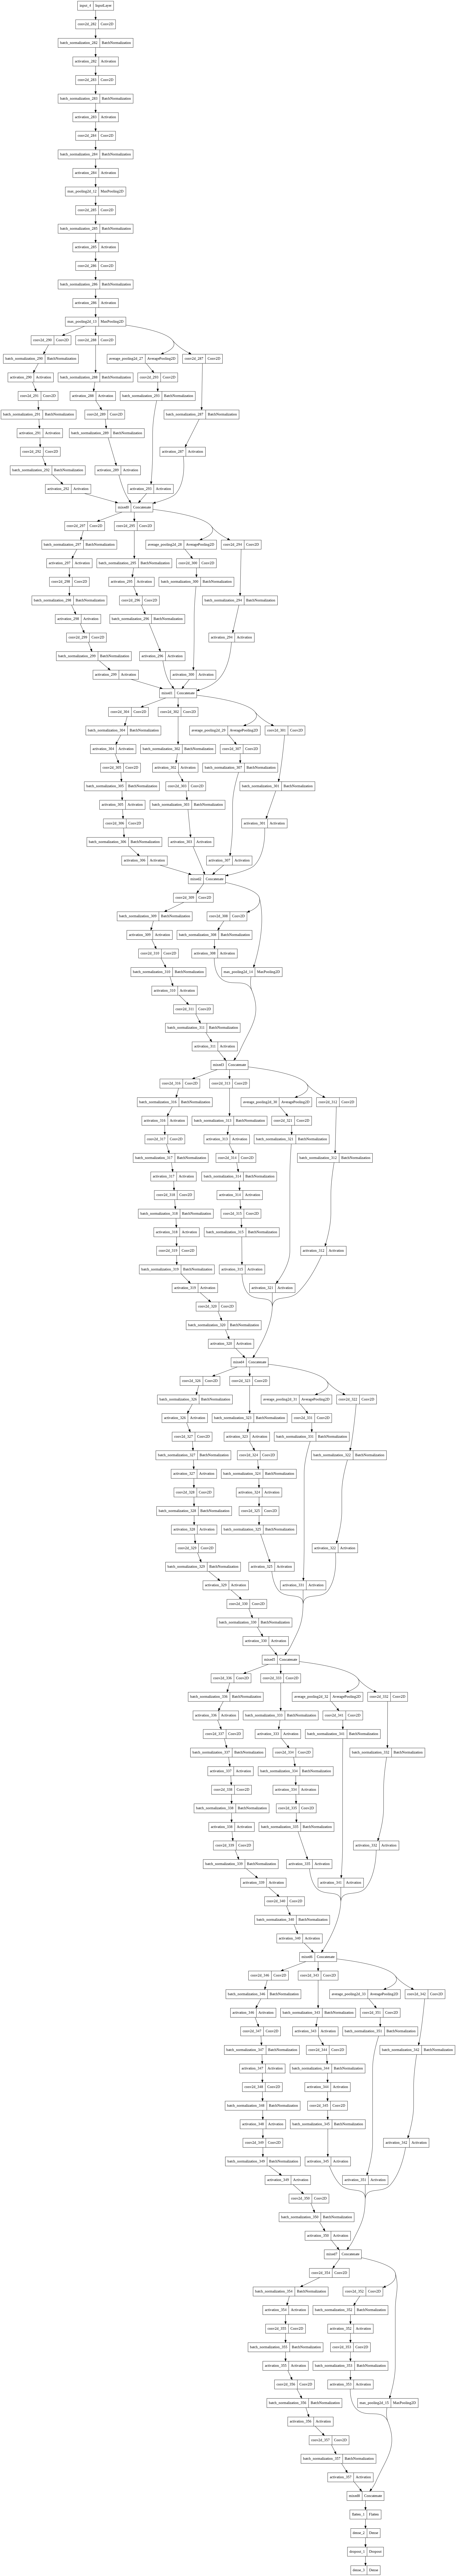

In [111]:
model.summary()
plot_model(model, to_file='inception_v3_with_dense_layers_model.png', show_shapes=False, show_layer_names=True)

In [112]:
train_dir = '/content/drive/MyDrive/Images2/trainF'
validation_dir = '/content/drive/MyDrive/Images2/validateF'


#train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,  height_shift_range=0.2, zoom_range=0.2,  shear_range=0.2, horizontal_flip=True, fill_mode='nearest')  # with data augmentation for train set

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)  # no augmentation for validation set

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=100,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))


validation_generator = valid_datagen.flow_from_directory(validation_dir,
                                                         batch_size=100,
                                                         class_mode='categorical',
                                                         target_size=(150, 150))

Found 639 images belonging to 14 classes.
Found 164 images belonging to 14 classes.


In [113]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > 0.99 and logs.get('val_acc') > 0.99):
            print("\nCancelling training as model has reached 99% accuracy and 99% validation accuracy!")
            self.model.stop_training = True

In [114]:
def plot_result(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

Prvo treniranje

---


steps_per_epoch=10,
                              epochs=10,
                              validation_steps=10,
                              verbose=2

In [115]:
callbacks = myCallback()
history = model.fit_generator(generator=train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=20,
                              epochs=3,
                              validation_steps=20,
                              verbose=2,
                              callbacks=[callbacks])

Epoch 1/3
20/20 - 176s - loss: 0.7709 - acc: 0.8035 - val_loss: 0.5178 - val_acc: 0.8354 - 176s/epoch - 9s/step
Epoch 2/3
20/20 - 173s - loss: 0.0443 - acc: 0.9995 - val_loss: 0.3663 - val_acc: 0.8841 - 173s/epoch - 9s/step
Epoch 3/3
20/20 - 169s - loss: 0.0165 - acc: 0.9978 - val_loss: 0.2677 - val_acc: 0.9268 - 169s/epoch - 8s/step


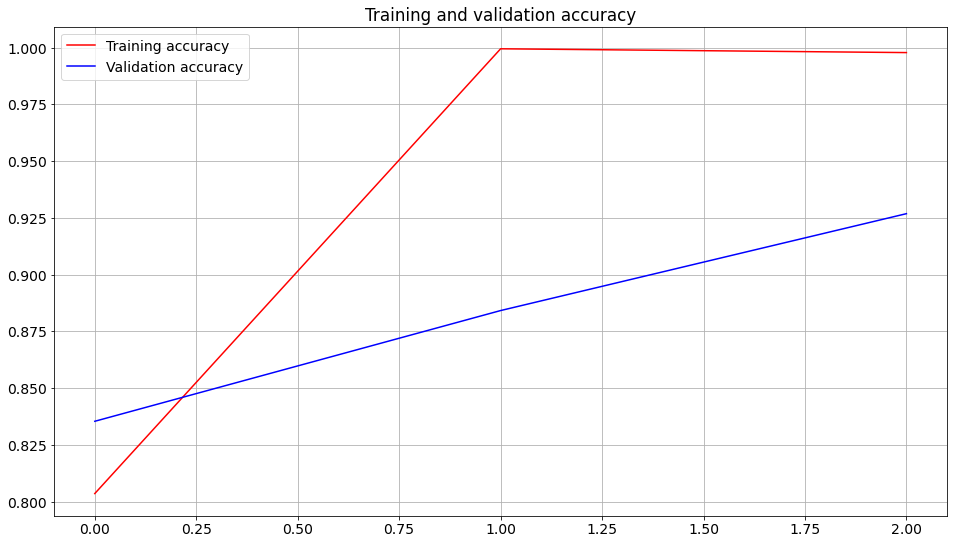

<Figure size 1152x648 with 0 Axes>

In [116]:
plot_result(history)

In [117]:
model.save("ModelV3.h5")

Text(0.5, 1.0, 'Grafik')

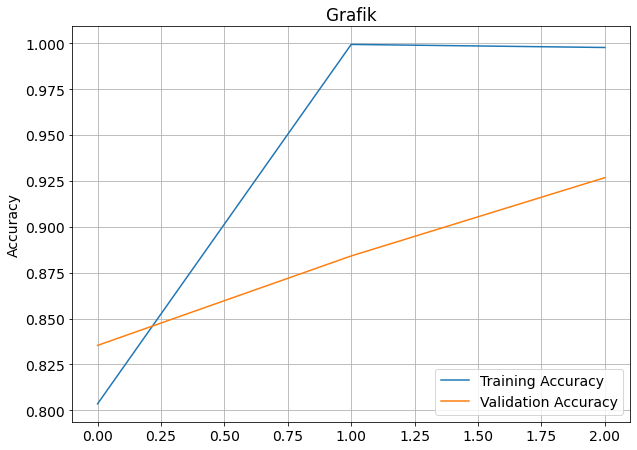

In [118]:
# store results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
  
  
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'Grafik')

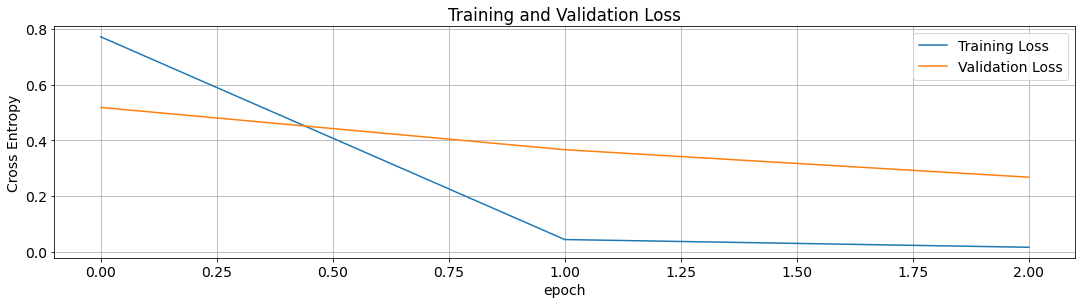

In [119]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [120]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100)) 
  
print("Loss: ",accuracy_score[0])

[0.2660757601261139, 0.9268293]
Accuracy: 92.6829%
Loss:  0.2660757601261139


In [121]:
import cv2

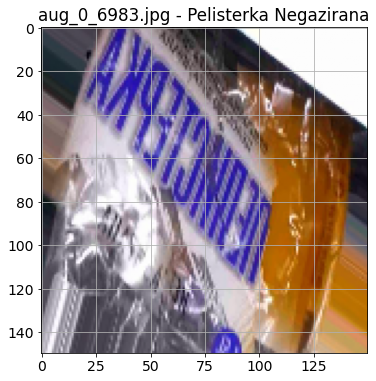

In [146]:
img_path =  '/content/drive/MyDrive/Images2/validateF/PelisterkaNegazirana/aug_0_6514.jpg'
img = cv2.imread(img_path)
resized_img = cv2.resize(img, (150, 150)).reshape(-1, 150, 150, 3)/255
  
plt.figure(figsize=(6,6))
plt.title("aug_0_6983.jpg - Pelisterka Negazirana")
plt.imshow(resized_img[0])

In [147]:
predictions = model.predict(validation_generator)
predictions[0]

array([7.4046792e-04, 4.8133955e-04, 2.1719325e-06, 7.6887076e-04,
       3.2811533e-04, 2.6528139e-04, 2.1788917e-05, 6.0138560e-04,
       5.8928177e-05, 3.8744463e-04, 5.9635854e-06, 9.9602807e-01,
       8.9362933e-05, 2.2071603e-04], dtype=float32)